# Labeling News Reports

## Introduction
This Project was created as part of Aalto University, Machine Learning D as a ML project with intention to solve a real-life problem with Machine Learning.

The specific idea is to labelize News Reports as either True or Fake to enable successfull creation of a model which can detect fake news.

##### *Performing library imports & loading the datasets into pandas (pd) dataframes*

In [1]:
# Loading libraries
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import sys

In [2]:
true_df = pd.read_csv('datasets/true.csv')
fake_df = pd.read_csv('datasets/fake.csv')

##### *First looks at true (non-fake) news dataset*

In [3]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
true_df.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


### Cleaning text column
It seems as if all texts start with "{city} (reuters) - " which I want removed.

A model will be affected by the fact that every true piece of news contains this prefix, while the fake ones don't.

Removing that before going further with inspection of datasets.

In [5]:
# Function for removing problematic prefix, if there is one
def remove_prefix(string):
    split = string.split("-", 1)
    if "(Reuters)" in string and len(split) > 1: 
        return split[1]
    return string
true_df['text'] = true_df.text.apply(lambda x: remove_prefix(x))

In [6]:
true_df.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017"


In [7]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
fake_df.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [9]:
print(f'True news subjects: {true_df.subject.unique()}')
print(f'Fake news subjects: {fake_df.subject.unique()}')

True news subjects: ['politicsNews' 'worldnews']
Fake news subjects: ['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


The unique subjects values are different for the different datasets, meaning that e.g. all articles labeled 'politics' are fake and 'politicNews' as a subject automatically means true.

In [10]:
true_df.drop(columns=['subject', 'date'], inplace=True)
fake_df.drop(columns=['subject', 'date'], inplace=True)

Labeling the dataframes and checking columns before merging dataframes:

In [11]:
true_df['label'] = True
fake_df['label'] = False

No null (i.e. NaN/missing) values, ok.

Column names match without typos etc. ok.

Both were previously quite populated with duplicates, so these will also be removed

In [12]:
df = pd.concat([true_df, fake_df], ignore_index=True).drop_duplicates()

## Implementation of ML

### *Idea*

 - Using *Bowl of Words (BoW)* and word frequency methods on the titles to classify articles as True or Fake.
 - Retrieving data from the structure of the text of the article such as average word length etc.

This way the project will remain computationally cheaper than using *NLP* methods combined with *ML* on the entire article.
An implementation such as this one also keeps the feature-to-datasize ratio acceptable, with a fairly large dataset of 40,000 instances.

## Tokenization and ML preperation

### Methods for the title and text
This section covers the preparation of features before implementation of **feature selection** and **machine learning.**
#### *Both:*
- Word tokenization
- Removing non-alphabetical characters
- Removing stop words, i.e. "filler words"
#### *Title:*
- Word stemming
- Creating a word-frequency dictionary
#### *Text:*
- Retrieving statistics on length (word, sentence and text length).
- Retrieving pos-tag statistics, i.e. how many subjectives, adjectives and verbs were used per instance.

### **Title feature extraction**

In [13]:
#Tokenizing & lowering
df['title'] = df['title'].apply(lambda title: nltk.word_tokenize(title.lower()))
df['text_word'] = df['text'].apply(lambda text: nltk.word_tokenize(text.lower()))

In [14]:
# Removing non-alphabethical words, such as websites
df['text_word'] = df['text_word'].apply(lambda text: list(filter(lambda word: word.isalpha(), text)))
df['title'] = df['title'].apply(lambda title: list(filter(lambda word: word.isalpha(), title)))

*Stop word dictionary*

In [15]:
fill_words = stopwords.words('english')
# The stopwords of the predifined dictionary
print(fill_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [16]:
# Removing the stop words
df['title'] = df.title.apply(lambda title: list(filter(lambda word: word not in fill_words, title)))

In [17]:
df['text_word'] = df.text_word.apply(lambda text: list(filter(lambda word: word not in fill_words, text)))

In [18]:
stemmer = SnowballStemmer('english')

In [19]:
df['title'] = df['title'].apply(lambda title: [stemmer.stem(word) for word in title])

In [20]:
df['word_frequencies'] = df['title'].apply(lambda text: nltk.probability.FreqDist(text))

### *Example*
A title turned into a frequency dictionary

In [21]:
df.title[25000]

['watch',
 'racist',
 'republican',
 'get',
 'hand',
 'claim',
 'trump',
 'campaign',
 'racist']

In [22]:
df['word_frequencies'][25000]

FreqDist({'racist': 2, 'watch': 1, 'republican': 1, 'get': 1, 'hand': 1, 'claim': 1, 'trump': 1, 'campaign': 1})

### **Text feature extraction**

Adding avg. word, sentence and text length.


In [23]:
# Lowering and tokenizing
df['text_sentence'] = df['text'].apply(lambda text: nltk.sent_tokenize(text.lower()))

In [24]:
# Adding new columns
df['avg_word_length'] = df.text_word.apply(lambda text: sum(map(len, text))/(1+len(text)))
df['avg_sentence_length'] = df.text_sentence.apply(lambda text: sum(map(len, text))/(1+len(text)))
df['text_length'] = df.text.apply(lambda text: len(text))

In [25]:
df.describe()

,avg_word_length,avg_sentence_length,text_length
count,39105.000000,39105.000000,39105.000000
mean,6.305612,155.194702,2416.499322
std,0.803979,65.237940,1942.972344
min,0.000000,0.000000,1.000000
25%,6.144330,125.937500,1256.000000
50%,6.402778,149.600000,2201.000000
75%,6.637755,175.285714,3072.000000
max,9.363636,4736.200000,51794.000000


In [26]:
df = df[df['text_length'] > 500]
df = df[df['avg_word_length'] > 0]

In [27]:
df.describe()

,avg_word_length,avg_sentence_length,text_length
count,35029.000000,35029.000000,35029.000000
mean,6.410720,162.949212,2663.550373
std,0.352430,62.454846,1904.154424
min,3.888748,36.875000,501.000000
25%,6.180851,132.545455,1651.000000
50%,6.421348,153.750000,2356.000000
75%,6.645485,179.000000,3226.000000
max,9.069444,4736.200000,51794.000000


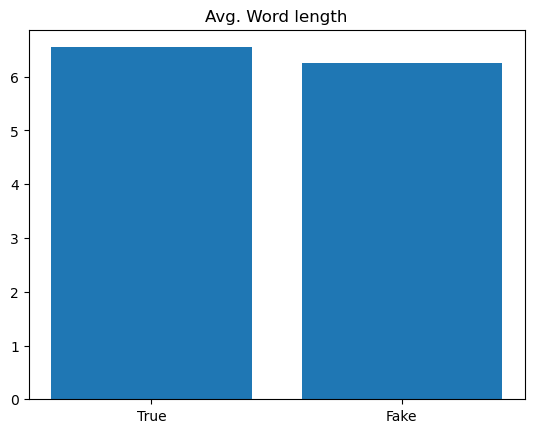

<Figure size 640x480 with 0 Axes>

In [28]:
plt.bar(["True", "Fake"], [df[df['label'] == True].avg_word_length.mean(), df[df['label'] == False].avg_word_length.mean()])
plt.title("Avg. Word length")
plt.show()
plt.clf()

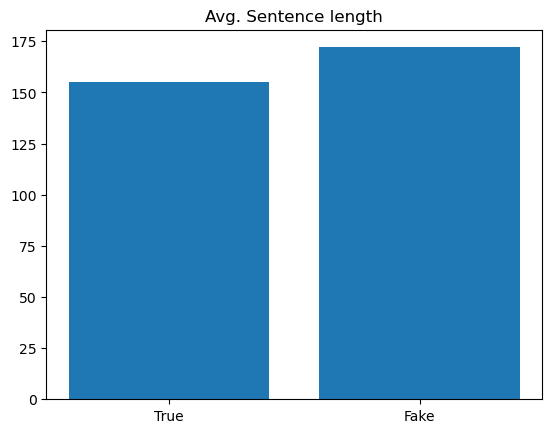

<Figure size 640x480 with 0 Axes>

In [29]:
plt.bar(["True", "Fake"], [df[df['label'] == True].avg_sentence_length.mean(), df[df['label'] == False].avg_sentence_length.mean()])
plt.title("Avg. Sentence length")
plt.show()
plt.clf()

##### **POS - tagging**
*A brief explanation of the process*
- Step 1: labeling each word as some type using nltk library
- Step 2: Creating a frequency for each type of word, e.g. adjective (JJ for short)
- Step 3: Retrieve verb, noun and adjective count for each instance in the dataset
- Step 4: Retrieving relative ratio of each type of word.
##### *Example with instance 0:*

In [30]:
# Step 1: Creating a pos_tag list of tuples
pos_list = nltk.pos_tag(df['text_word'][0])
# Printing first ten
print(pos_list[0:10])

[('head', 'NN'), ('conservative', 'JJ'), ('republican', 'JJ'), ('faction', 'NN'), ('congress', 'NN'), ('voted', 'VBD'), ('month', 'NN'), ('huge', 'JJ'), ('expansion', 'NN'), ('national', 'JJ')]


In [31]:
# Step 2: Creating a Frequency dictionary
freq_dict = nltk.FreqDist(tag for (word, tag) in pos_list)
print(dict(freq_dict))

{'NN': 161, 'JJ': 73, 'VBD': 24, 'NNS': 59, 'VBN': 13, 'VBG': 14, 'IN': 3, 'VBP': 26, 'RB': 19, 'VBZ': 9, 'VB': 8, 'MD': 5, 'NNP': 1, 'CD': 6, 'JJS': 2, 'RP': 2}


In [32]:
# Step 3: Retrieving the type of word we want, for example adjective (JJ)
freq_dict['JJ']

73

In [33]:
# Everything written on one line looks like this
nltk.FreqDist(tag for (word, tag) in nltk.pos_tag(df['text_word'][0]))['JJ']

73

In [34]:
# Here's how the different percentages look
for i in freq_dict.keys():
    print(f"Percentage of {i}: {100*(freq_dict[i]/sum(freq_dict.values()))}%")

Percentage of NN: 37.88235294117647%
Percentage of JJ: 17.176470588235293%
Percentage of VBD: 5.647058823529412%
Percentage of NNS: 13.882352941176471%
Percentage of VBN: 3.058823529411765%
Percentage of VBG: 3.294117647058824%
Percentage of IN: 0.7058823529411765%
Percentage of VBP: 6.11764705882353%
Percentage of RB: 4.470588235294118%
Percentage of VBZ: 2.1176470588235294%
Percentage of VB: 1.8823529411764703%
Percentage of MD: 1.1764705882352942%
Percentage of NNP: 0.2352941176470588%
Percentage of CD: 1.411764705882353%
Percentage of JJS: 0.4705882352941176%
Percentage of RP: 0.4705882352941176%


***Implementation***

In [35]:
df['counts'] = df.text_word.apply(lambda text: nltk.FreqDist(tag for (word, tag) in nltk.pos_tag(text)))

Getting all tags:

In [36]:
all_tags = set(tag for freq_dist in df['counts'] for tag in freq_dist.keys())

Getting the ratio of each:

In [37]:
for i in all_tags:
    df[i + "_ratio"] = df.apply(lambda row: row['counts'].get(i, 0) / sum(row['counts'].values()), axis=1)

In [38]:
df.drop(columns = ['counts'], inplace=True)

In [39]:
df.head()

,title,text,label,text_word,word_frequencies,text_sentence,avg_word_length,avg_sentence_length,text_length,VBN_ratio,...,PRP_ratio,CC_ratio,POS_ratio,$_ratio,RB_ratio,SYM_ratio,TO_ratio,WRB_ratio,NNS_ratio,VBZ_ratio
0,"[budget, fight, loom, republican, flip, fiscal...",The head of a conservative Republican faction...,True,"[head, conservative, republican, faction, cong...","{'budget': 1, 'fight': 1, 'loom': 1, 'republic...",[ the head of a conservative republican factio...,6.610329,164.607143,4637,0.030588,...,0.000000,0.0,0.0,0.0,0.044706,0.0,0.0,0.0,0.138824,0.021176
1,"[militari, accept, transgend, recruit, monday,...",Transgender people will be allowed for the fi...,True,"[transgender, people, allowed, first, time, en...","{'militari': 1, 'accept': 1, 'transgend': 1, '...",[ transgender people will be allowed for the f...,7.118980,212.473684,4055,0.036932,...,0.000000,0.0,0.0,0.0,0.017045,0.0,0.0,0.0,0.142045,0.008523
2,"[senior, republican, senat, mueller, job]",The special counsel investigation of links be...,True,"[special, counsel, investigation, links, russi...","{'senior': 1, 'republican': 1, 'senat': 1, 'mu...",[ the special counsel investigation of links b...,6.537255,152.555556,2767,0.031496,...,0.003937,0.0,0.0,0.0,0.023622,0.0,0.0,0.0,0.086614,0.015748
3,"[fbi, russia, probe, help, australian, diploma...",Trump campaign adviser George Papadopoulos to...,True,"[trump, campaign, adviser, george, papadopoulo...","{'fbi': 1, 'russia': 1, 'probe': 1, 'help': 1,...",[ trump campaign adviser george papadopoulos t...,6.812785,151.500000,2439,0.009174,...,0.000000,0.0,0.0,0.0,0.036697,0.0,0.0,0.0,0.119266,0.000000
4,"[trump, want, postal, servic, charg, amazon, s...",President Donald Trump called on the U.S. Pos...,True,"[president, donald, trump, called, postal, ser...","{'trump': 1, 'want': 1, 'postal': 1, 'servic':...",[ president donald trump called on the u.s. po...,6.461864,142.444444,5174,0.019108,...,0.000000,0.0,0.0,0.0,0.044586,0.0,0.0,0.0,0.138004,0.012739


In [1]:
# This part was commented out when turning notebook into pdf to reduce the length of the document.
# for i in all_tags:
#     plt.bar(["True", "Fake"], [df[df['label'] == True][i+'_ratio'].mean(), df[df['label'] == False][i+'_ratio'].mean()], color = ['#228B22', 'r'])
#     plt.title(i + " Ratio")
#     plt.show()
#     plt.clf()

## Model Training
#### *Features:*
***Bowl of word - model***
- Turning the frequency of each word into a feature, by vectorizing.

***Text structure - model***
- Taking the POS-tagged ratios and text-statistics as features.

In [41]:
vectorizer = DictVectorizer(sparse=False)

In [42]:
title_X = vectorizer.fit_transform(df['word_frequencies'])

In [43]:
text_X = df.drop(columns = ['title', 'text', 'text_word', 'text_sentence', 'word_frequencies', 'label'])

**Amount of words (features) in the BoW**

In [44]:
len(vectorizer.vocabulary_)

12343

#### Combining features

In [45]:
title_X_df = pd.DataFrame(title_X) # Making the title_X ready for merge

In [46]:
# title_X_df = title_X_df.loc[:, (title_X_df.max() > 1)]

In [47]:
X = title_X_df.join(text_X).fillna(0)

In [48]:
X.columns = X.columns.astype(str)

In [49]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,PRP_ratio,CC_ratio,POS_ratio,$_ratio,RB_ratio,SYM_ratio,TO_ratio,WRB_ratio,NNS_ratio,VBZ_ratio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.044706,0.0,0.0,0.0,0.138824,0.021176
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.017045,0.0,0.0,0.0,0.142045,0.008523
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003937,0.0,0.0,0.0,0.023622,0.0,0.0,0.0,0.086614,0.015748
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.036697,0.0,0.0,0.0,0.119266,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.044586,0.0,0.0,0.0,0.138004,0.012739


In [50]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,PRP_ratio,CC_ratio,POS_ratio,$_ratio,RB_ratio,SYM_ratio,TO_ratio,WRB_ratio,NNS_ratio,VBZ_ratio
count,35029.000000,35029.000000,35029.000000,35029.000000,35029.000000,35029.000000,35029.000000,35029.000000,35029.000000,35029.000000,...,35029.000000,35029.000000,35029.000000,3.502900e+04,35029.000000,3.502900e+04,35029.000000,35029.000000,35029.000000,35029.000000
mean,0.000029,0.000057,0.000029,0.000029,0.000371,0.001085,0.000400,0.000057,0.000856,0.000029,...,0.001025,0.000420,0.000012,2.660420e-07,0.042011,4.443919e-07,0.000082,0.000078,0.107146,0.013440
std,0.005343,0.007556,0.005343,0.005343,0.019261,0.032919,0.021369,0.007556,0.029253,0.005343,...,0.003044,0.001605,0.000260,3.833561e-05,0.025957,4.129128e-05,0.001092,0.000700,0.051727,0.011740
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.025735,0.000000e+00,0.000000,0.000000,0.081633,0.004425
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.040865,0.000000e+00,0.000000,0.000000,0.111801,0.011945
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.057348,0.000000e+00,0.000000,0.000000,0.140741,0.019737
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,0.064000,0.031250,0.017857,6.666667e-03,0.206349,5.050505e-03,0.085366,0.020833,0.372093,0.125000


#### Train - validation - test set splitting
Using train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, df.label, test_size=0.1, random_state=42)

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # Which y one uses is irrelevant, since they are the same

In [53]:
print(f"Number of features wanted: {round(len(X_train)/10)}")

Number of features wanted: 2522


#### Conclusion before ML

- The training set allows for an approximate maximum of 3000 features based on it's length
- We can narrow this down using feature selection methods

In [54]:
# Function for printing model score

def printModelScore(model, xtr, xte, ytr, yte):
    print(f"Model training score: {model.score(xtr, ytr)}")
    print(f"Model testing score: {model.score(xte, yte)}")

#### L1 models:

To find out how the model reacts to the amount of features 3 models:
* C=0.5, should zero out more than standard of 1
* C=1
* C=2 should zero out less, making room for more features

In [55]:
L1_lr_model0_5 = LogisticRegression(solver="liblinear", penalty="l1", C=0.5)

In [56]:
L1_lr_model1 = LogisticRegression(solver="liblinear", penalty="l1", C=1)

In [57]:
L1_lr_model2 = LogisticRegression(solver="liblinear", penalty="l1", C=2)

*Fitting the models*

In [58]:
L1_lr_model0_5.fit(X_train, y_train)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')

In [59]:
L1_lr_model1.fit(X_train, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [60]:
L1_lr_model2.fit(X_train, y_train)

LogisticRegression(C=2, penalty='l1', solver='liblinear')

*Model Performance*

In [61]:
printModelScore(L1_lr_model0_5, X_train, X_val, y_train, y_val)

Model training score: 0.9567010309278351
Model testing score: 0.9351411354265778


In [62]:
printModelScore(L1_lr_model1, X_train, X_val, y_train, y_val)

Model training score: 0.9701030927835051
Model testing score: 0.9427529337139232


In [63]:
printModelScore(L1_lr_model2, X_train, X_val, y_train, y_val)

Model training score: 0.9878667724028549
Model testing score: 0.9441801458928005


*Amount of features per model*

In [64]:
relevant0_5 = [coef for coef in list(L1_lr_model0_5.coef_[0]) if coef != 0]

In [65]:
len(relevant0_5)

1041

In [66]:
relevant1 = [coef for coef in list(L1_lr_model1.coef_[0]) if coef != 0]

In [67]:
len(relevant1)

1561

In [68]:
relevant2 = [coef for coef in list(L1_lr_model2.coef_[0]) if coef != 0]

In [69]:
len(relevant2)

2216

#### Result of L1 regression

The logistic regression model with the L1 loss function managed to zero out all but 1700 features, which it clarified as relevant by assigning them a coef. Changing the C hyperparameter to 0.5 made it use 1112 which saw a reduction in both overfitting and performance, while increasing it to 2 saw both increase.

#### L2 model:

To best perform feature selection with L2 regression, there might be need for a sequential feature selection process.

L2 without feature selection:

In [70]:
L2_lr_model = LogisticRegression(penalty='l2')

In [71]:
L2_lr_model.fit(X_train, y_train)

C:\Users\jonne\anaconda3\envs\MLwNLP\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [72]:
printModelScore(L2_lr_model, X_train, X_val, y_train, y_val)

Model training score: 0.8863600317208564
Model testing score: 0.878686964795433


In [73]:
relevantL2 = [coef for coef in list(L2_lr_model.coef_[0]) if coef != 0]

In [74]:
len(relevantL2)

11127

*Conclusion:* without feature selection, the model tries to analyze too many features of the dataset.

By performing sequential feature selection, this can be overcome.

#### Plotting Results

C:\Users\jonne\AppData\Local\Temp\ipykernel_9096\3579831613.py:11: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax[indexes[j]].set_ylim(0.8, 1, 0.2)
C:\Users\jonne\AppData\Local\Temp\ipykernel_9096\3579831613.py:11: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax[indexes[j]].set_ylim(0.8, 1, 0.2)
C:\Users\jonne\AppData\Local\Temp\ipykernel_9096\3579831613.py:11: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax[indexes[j]].set_ylim(0.8, 1, 0.2)
C:\Users\jonne\AppData\Local\Temp\ipykernel_9096\3579831613.py:11: MatplotlibDeprecationWarning: Passing the emit parameter of 

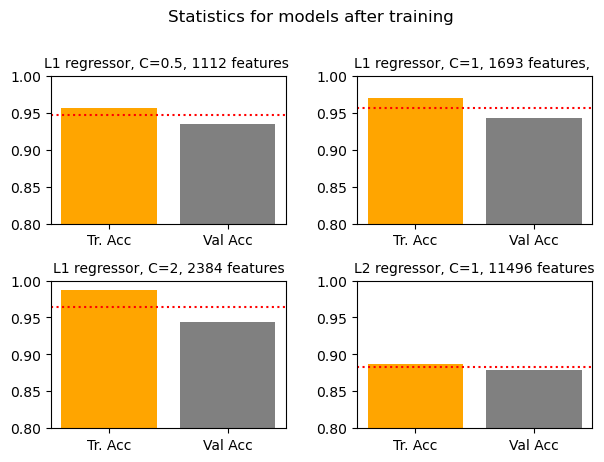

In [89]:
fig, ax = plt.subplots(2,2)
fig.suptitle("Statistics for models after training")
fig.tight_layout(pad=2.0)
indexes = [(0,0), (0,1), (1,0), (1,1)]
titles = ["L1 regressor, C=0.5, 1112 features ", "L1 regressor, C=1, 1693 features, ", "L1 regressor, C=2, 2384 features", "L2 regressor, C=1, 11496 features"]
j = 0
for i in [L1_lr_model0_5, L1_lr_model1, L1_lr_model2, L2_lr_model]:
    ax[indexes[j]].bar(["Tr. Acc", "Val Acc"], [i.score(X_train, y_train), i.score(X_val, y_val)], color=["orange", "grey", "blue"])
    ax[indexes[j]].axhline(y = (i.score(X_train, y_train) + i.score(X_test, y_test))/2 , color = 'r', linestyle=':')
    ax[indexes[j]].set_title(titles[j], size=10)
    ax[indexes[j]].set_ylim(0.8, 1, 0.2)
    j = j+1
plt.show()

#### *RFC model:*
 - **RFC**: RandomForestClassifier from sklearn library
 -  The feature selection will be done by cross-validation at the same time as hyperparameter tuning. To reduce computational resources required, the Randomized Search algorithm will be used.
 -  The best model will then be compared to the performance of the LogisticRegression models to see which alternative is prefarable and whether
combining them can be to any help.

In [76]:
RFC = RandomForestClassifier()

In [77]:
RandomSearch1 = RandomizedSearchCV(
    RFC,
    param_distributions = {
            
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [True]
    },
    cv = 3,
    n_jobs = 4,
    random_state = 42
)

In [78]:
RandomSearch1.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42)

In [79]:
RandomSearch1.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [80]:
printModelScore(RandomSearch1.best_estimator_, X_train, X_val, y_train, y_val)

Model training score: 0.9581284694686757
Model testing score: 0.9199175388518871


Going further to visualize the difference in performance with confusion matrices

In [81]:
RFC = RandomSearch1.best_estimator_

In [90]:
rfc_pred = RandomSearch1.best_estimator_.predict(X_val)

In [91]:
lr_pred = L1_lr_model1.predict(X_val)

In [92]:
conf_matR = confusion_matrix(rfc_pred, y_val)

In [93]:
conf_matL = confusion_matrix(lr_pred, y_val)

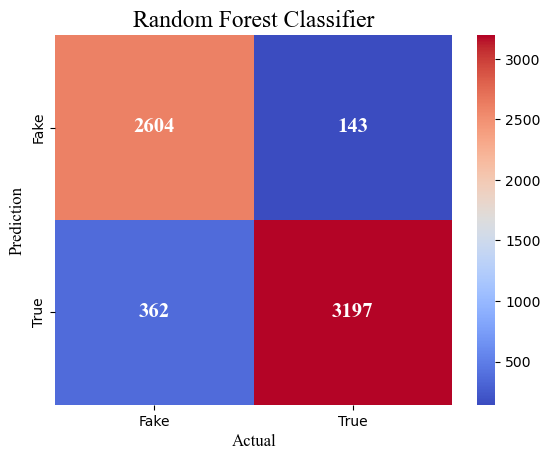

In [99]:
sns.heatmap(conf_matR,
            xticklabels=['Fake','True'],
            yticklabels=['Fake','True'],
           fmt = 'g',
           cmap = 'coolwarm',
           annot = True,
           annot_kws = {'size': 15, 'weight': 'bold', 'family': 'Times New Roman'})
plt.ylabel('Prediction',fontsize=12, fontfamily="Times New Roman")
plt.xlabel('Actual',fontsize=12, fontfamily="Times New Roman")
plt.title('Random Forest Classifier', fontsize=17, fontfamily="Times New Roman")
plt.show()

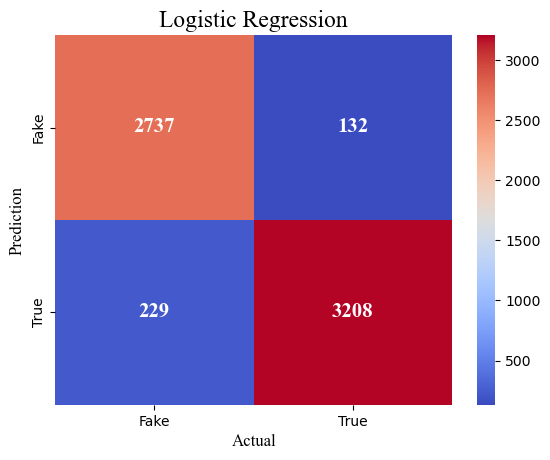

In [101]:
sns.heatmap(conf_matL, 
            annot=True,
            xticklabels=['Fake','True'],
            yticklabels=['Fake','True'],
           fmt = 'g',
           cmap = 'coolwarm',
           annot_kws = {'size': 15, 'weight': 'bold', 'family': 'Times New Roman'})
plt.ylabel('Prediction',fontsize=12, fontfamily="Times New Roman")
plt.xlabel('Actual',fontsize=12, fontfamily="Times New Roman")
plt.title('Logistic Regression', fontsize=17, fontfamily="Times New Roman")
plt.show()

### Final Test
*As the **Logistic Regression** model performed a lot better, it was chosen. Finally testing how well it performed on test data.*

In [88]:
printModelScore(L1_lr_model1, X_train, X_test, y_train, y_test)

Model training score: 0.9701030927835051
Model testing score: 0.941764202112475
